This python notebook is based on the book "Python for Finance: Mastering Data-Driven Finance" by Yves Hilpisch.

Elaborated by: Francisco Arizola

# Part III: Financial Data Science

## Chapter 10: Performance Python

This chapter is about approaches to speed up typical tasks and algorithms often encountered in a financial context.

In [1]:
# Import necessary libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import math

# Style pyplot with serif font
plt.rcParams['font.family'] = 'serif'

# 3D plotting library
from mpl_toolkits.mplot3d import Axes3D

# Comment the next line if you do not have cufflinks and plotly installed
!pip install cufflinks plotly

import pandas as pd
import cufflinks as cf 
import plotly.offline as plyo

# Initialize plotly to work in offline mode
plyo.init_notebook_mode(connected=True)

# Optional: if you are using Jupyter Notebook, you might want to enable inline plotting
cf.go_offline()

### Loops

#### Pure Python

In [2]:
# Define function to calculate the mean of a random series
def average_py(n):
 s = 0
 for i in range(n):
     s += random.random()
 return s / n

In [3]:
n = 10000000

%time average_py(n) # Times the function once

CPU times: total: 625 ms
Wall time: 765 ms


0.49998831094144003

In [4]:
%timeit average_py(n) # Times the function multiple times for a more reliable estimate

717 ms ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%time sum([random.random() for _ in range(n)]) / n 

CPU times: total: 891 ms
Wall time: 1.23 s


0.4998267403822669

#### Numpy
Now, we can try using Numpy. We'll see that the speedup is considerable, reaching almost a factor of 10 or an order of magnitude. However, the price that must be paid is significantly higher memory usage.

In [6]:
# Function to draw the random numbers “all at once” (no Python loop)
def average_np(n):
 s = np.random.random(n)
 return s.mean()

%time average_np(n)

CPU times: total: 93.8 ms
Wall time: 99.8 ms


0.4999920937704543

In [7]:
%timeit average_np(n)

106 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
s = np.random.random(n)
s.nbytes

80000000

#### Numba
Thirdly, we evaluate Numba. Numba is a package that allows the dynamic compiling of pure Python code. The combination of pure Python with Numba beats the NumPy version and preserves the memory efficiency of the original loop-based implementation.

In [9]:
# Importar Numba
import numba

# Time a numba version
average_nb = numba.jit(average_py) # This creates the Numba function.
%time average_nb(n)

C:\Users\Franc\AppData\Local\Temp\ipykernel_36672\3021667931.py:5: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



CPU times: total: 234 ms
Wall time: 751 ms


0.5002230444891389

In [10]:
%time average_nb(n) # From the second execution (with the same input data types), the execution is faster.

CPU times: total: 62.5 ms
Wall time: 85.5 ms


0.4998853995133602

In [11]:
%timeit average_nb(n) 

71.4 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Algorithms

#### Python

The code that follows presents a Python implementation that creates a recombining tree based on some fixed numerical parameters for the model.

In [12]:
# Function to evaluate if a number is prime or not (it only evaluates the numbers below the square root of the number)
def is_prime(I):
 if I % 2 == 0: return False
 for i in range(3, int(I ** 0.5) + 1, 2):
        if I % i == 0: return False
 return True

In [13]:
n = int(1e8 + 3)
n

100000003

In [14]:
%time is_prime(n)

CPU times: total: 0 ns
Wall time: 0 ns


False

In [15]:
p1 = int(1e8 + 7)
p1

100000007

In [16]:
%time is_prime(p1)

CPU times: total: 0 ns
Wall time: 0 ns


True

In [17]:
p2 = 100109100129162907
p2.bit_length()

57

In [18]:
%time is_prime(p2) # It takes nearly 9 seconds (a lot!)

CPU times: total: 7.88 s
Wall time: 10.1 s


True

#### Numba

In [19]:
is_prime_nb = numba.jit(is_prime)

C:\Users\Franc\AppData\Local\Temp\ipykernel_36672\2261114259.py:1: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



In [20]:
%time is_prime_nb(n)

CPU times: total: 109 ms
Wall time: 110 ms


False

In [21]:
%time is_prime_nb(n)

CPU times: total: 0 ns
Wall time: 0 ns


False

In [22]:
%time is_prime_nb(p1)

CPU times: total: 0 ns
Wall time: 0 ns


True

In [23]:
%time is_prime_nb(p2) # The speedup for the larger prime is about an order of magnitude.

CPU times: total: 406 ms
Wall time: 543 ms


True

#### Multiprocessing

So far, all the optimization efforts have focused on the sequential code execution. In particular with prime numbers, there might be a need to check multiple numbers at the same time. To this end, the multiprocessing module can help speed up the code
execution further. It allows one to spawn multiple Python processes that run in parallel.

In [24]:
# Import multiprocessing library
import multiprocessing as mp

In [25]:
# The mp.Pool object is instantiated with multiple processes.
pool = mp.Pool(processes=4)

In [26]:
# We time the numba version for a 10 item list
%time pool.map(is_prime_nb, 10 * [p2])

CPU times: total: 0 ns
Wall time: 2.74 s


[True, True, True, True, True, True, True, True, True, True]

The Numba version once again offers great speed posibilities

### Binomial Trees

The **binomial option pricing model** is a numerical method used to value options. Developed by Cox, Ross, and Rubinstein in 1979, this method represents the future evolution of an asset's price using a binomial tree. Here's a detailed explanation:

#### Key Concepts:

##### Tree Representation
- The model uses a **binomial tree** to represent possible future movements of the asset price.
- Each node in the tree represents a potential price at a specific point in time.

##### Risky and Riskless Assets
- **Risky Asset**: Typically a stock or index with uncertain price movements.
- **Riskless Asset**: Usually a bond or other risk-free investment that grows at a constant rate $r$.

##### Time Intervals
- The time from the present until the option's maturity is divided into **equidistant subintervals** of length $\Delta t$.

##### Price Movements
- At each time step, the price of the asset can either:
  - **Increase**: The price at time $t$ is $S_{t} = S_{s} \cdot u$.
  - **Decrease**: The price at time $t$ is $S_{t} = S_{s} \cdot d$.
- Here, $S_{s}$ is the price at the current time $s$, and $S_{t}$ is the price at time $t$.

##### Factors $u$ and $d$
- **Up Factor $u$**: The factor by which the price increases, calculated as $u = e^{\sigma \sqrt{\Delta t}}$, where $\sigma$ is the volatility.
- **Down Factor $d$**: The factor by which the price decreases, calculated as $d = \frac{1}{u}$.
- These factors ensure $0 < d < e^{r \Delta t} < u$, where $e^{r \Delta t}$ is the growth factor of the risk-free asset.
- Additionally, $u = \frac{1}{d}$ to ensure the tree is recombining.

##### Risk-Free Rate
- $r$ is the constant **risk-free short rate**, the rate of return on a risk-free asset.

#### Example Calculation:

Suppose:
- Current stock price is $S_{s}$.
- Up factor $u = e^{\sigma \sqrt{\Delta t}}$.
- Down factor $d = \frac{1}{u}$.

In one time step of length $\Delta t$:
- The stock price can increase to $S_{t} = S_{s} \cdot u$.
- The stock price can decrease to $S_{t} = S_{s} \cdot d$.

By constructing and analyzing the binomial tree, you can work backward from the option's expiry to today to determine its value.

This model is valued for its simplicity and intuitive approach compared to more complex models like Black-Scholes.

#### Python

In [27]:
# Define parameters
S0 = 36 # Initial value of the risky asset
T = 1.0 # Time horizon for the binomial tree simulation
r = 0.06 # Constant short rate
sigma = 0.2 # Constant volatility factor

In [28]:
def simulate_tree(M):
 dt = T / M # Length of time intervals
 u = math.exp(sigma * math.sqrt(dt)) # Factors for the upward movements
 d = 1 / u # Factors for the downward movements
 S = np.zeros((M + 1, M + 1))
 S[0, 0] = S0
 z = 1
 for t in range(1, M + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1
 return S

In [29]:
# Set 'print' options with two decimals
np.set_printoptions(formatter={'float':
                                 lambda x: '%6.2f' % x})

# Tree with 4 time intervals
simulate_tree(4)

array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [30]:
# Tree with 500 time intervals.
%time simulate_tree(500)

CPU times: total: 62.5 ms
Wall time: 92.3 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

#### Numba

In [31]:
# Numba function
simulate_tree_nb = numba.jit(simulate_tree)

# Simulation with 4 time intervals
simulate_tree_nb(4)

C:\Users\Franc\AppData\Local\Temp\ipykernel_36672\2537181362.py:2: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



array([[ 36.00,  39.79,  43.97,  48.59,  53.71],
       [  0.00,  32.57,  36.00,  39.79,  43.97],
       [  0.00,   0.00,  29.47,  32.57,  36.00],
       [  0.00,   0.00,   0.00,  26.67,  29.47],
       [  0.00,   0.00,   0.00,   0.00,  24.13]])

In [32]:
# Time simulation with a 500 time intervals
%time simulate_tree_nb(500)

CPU times: total: 0 ns
Wall time: 1.01 ms


array([[ 36.00,  36.32,  36.65, ..., 3095.69, 3123.50, 3151.57],
       [  0.00,  35.68,  36.00, ..., 3040.81, 3068.13, 3095.69],
       [  0.00,   0.00,  35.36, ..., 2986.89, 3013.73, 3040.81],
       ...,
       [  0.00,   0.00,   0.00, ...,   0.42,   0.42,   0.43],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.41,   0.42],
       [  0.00,   0.00,   0.00, ...,   0.00,   0.00,   0.41]])

In [33]:
%timeit simulate_tree_nb(500)

802 µs ± 94.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Monte Carlo Simulation

This section analyzes the Monte Carlo simulation of the geometric Brownian motion, a simple yet still widely used stochastic process to model the evolution of stock prices or index levels. Among others, the Black-Scholes-Merton (1973) theory of option pricing draws on this process. In their setup, the underlying of the option to be valued follows the stochastic differential equation (SDE), as seen in Equation 10-1. $S_t$ is the value of the underlying at time $t$; $r$ is the constant, riskless short rate; $\sigma$ is the constant instantaneous volatility; and $Z_t$ is a Brownian motion.

#### Equation 10-1. Black-Scholes-Merton SDE (geometric Brownian motion)
$$
dS_t = r S_t dt + \sigma S_t dZ_t
$$

##### Interpretation:

- **Drift Term ($ \mu S_t dt $)**: This term represents the deterministic part of the price change, contributing to the average growth rate of the asset over time.
- **Volatility Term ($ \sigma S_t dZ_t $)**: This term introduces randomness into the price change, capturing the unpredictable fluctuations due to market forces.

#### Equation 10-2. Black-Scholes-Merton difference equation (Euler scheme)

The previous SDE can be discretized over equidistant time intervals and simulated according to Equation 10-2, which represents an Euler scheme. In this case, $z$ is a standard normally distributed random number. For $M$ time intervals, the length of the time interval is given as $\Delta t = \frac{T}{M}$, where $T$ is the time horizon for the simulation (for example, the maturity date of an option to be valued).

$$
S_t = S_{t - \Delta t} \exp \left( \left( r - \frac{\sigma^2}{2} \right) \Delta t + \sigma \sqrt{\Delta t} \, z \right)
$$

#### Key Concepts:

##### Geometric Brownian Motion (GBM)
- GBM is a stochastic process used to model stock prices.
- The process assumes continuous compound growth with a drift term ($r$) and a volatility term ($\sigma$).
- **Drift**: This represents the average rate of return of the asset, often denoted by $ \mu $ or $ r $. It accounts for the deterministic trend in the price movement.
- **Volatility**: Represented by $ \sigma $, this measures the degree of randomness or uncertainty in the price movement. Higher volatility indicates greater uncertainty and larger potential price swings.

##### Monte Carlo Simulation
- A method to simulate the potential future outcomes of a GBM by generating a large number of random paths.
- Each path represents a possible evolution of the stock price over time.

##### Stochastic Differential Equation (SDE)
- The SDE for GBM is given by Equation 10-1.
- This equation describes the continuous change in the stock price, incorporating both the deterministic trend and the stochastic volatility.

##### Discretization and Euler Scheme
- To simulate GBM, the continuous SDE is discretized using the Euler scheme.
- The discretized equation (Equation 10-2) allows for the numerical simulation of stock prices over discrete time intervals.

The Monte Carlo estimator for a European call option is a method used to estimate the option's price using simulated paths of the underlying asset's price. This approach relies on generating a large number of potential future price paths and then averaging the payoff of the option across these paths. The key formula for the Monte Carlo estimator is given by Equation 10-3.

#### Equation 10-3. Monte Carlo Estimator for European Call Option

$$
C_0 = e^{-rT} \frac{1}{I} \sum_{i=1}^{I} \max(S_T^{(i)} - K, 0)
$$

##### Explanation

- **$C_0$**: The estimated price of the European call option at time 0.
- **$e^{-rT}$**: The discount factor, which accounts for the time value of money. Here, $r$ is the risk-free rate, and $T$ is the time to maturity.
- **$I$**: The total number of simulated paths.
- **$S_T^{(i)}$**: The $i$-th simulated value of the underlying asset at maturity $T$.
- **$K$**: The strike price of the option.
- **$\max(S_T^{(i)} - K, 0)$**: The payoff of the call option for the $i$-th simulated path. This represents the intrinsic value of the option, which is the positive difference between the asset price at maturity and the strike price, or zero if the difference is negative.

#### Python

In [38]:
M = 100 # The number of time intervals for discretization.
I = 50000 # The number of paths to be simulated.

# Function for Monte Carlo simulation
def mcs_simulation_py(p):
 M, I = p
 dt = T / M
 S = np.zeros((M + 1, I))
 S[0] = S0
 rn = np.random.standard_normal(S.shape)
 #The nested loop implementing the simulation based on the Euler scheme.
 for t in range(1, M + 1):
     for i in range(I):
         S[t, i] = S[t-1, i] * math.exp((r - sigma ** 2 / 2) * dt + sigma * math.sqrt(dt) * rn[t, i])
 return S

In [39]:
%timeit S = mcs_simulation_py((M, I))

5.19 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
%time S = mcs_simulation_py((M, I))

# The mean end-of-period value based on the simulation
S[-1].mean()

CPU times: total: 4.7 s
Wall time: 5.28 s


38.289741809280926

In [42]:
# The theoretically expected end-of-period value
S0 * math.exp(r * T)

38.22611567563295

In [43]:
# The strike price of the European put option
K = 40

# The Monte Carlo estimator for the option
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean()
C0

3.852025291365972

#### Numpy

In [44]:
# Function for Monte Carlo simulation
def mcs_simulation_np(p):
 M, I = p
 dt = T / M
 S = np.zeros((M + 1, I))
 S[0] = S0
 rn = np.random.standard_normal(S.shape)
 for t in range(1, M + 1):
     S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * math.sqrt(dt) * rn[t])
 return S

In [45]:
# Time the simulation time
%time S = mcs_simulation_np((M, I))

CPU times: total: 156 ms
Wall time: 203 ms


In [46]:
# The mean end-of-period value based on the simulation
S[-1].mean()

38.23808096960891

In [47]:
%timeit S = mcs_simulation_np((M, I)) # The numpy version is extremly faster than the Python version

180 ms ± 18.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Numba

In [49]:
mcs_simulation_nb = numba.jit(mcs_simulation_py)

C:\Users\Franc\AppData\Local\Temp\ipykernel_36672\2190167922.py:1: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



In [50]:
%timeit S = mcs_simulation_nb((M, I))

163 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
S[-1].mean()

38.289741809280926

In [52]:
C0 = math.exp(-r * T) * np.maximum(K - S[-1], 0).mean()
C0

3.815253236131366

#### Multiprocessing

Monte Carlo simulation is a task that lends itself well to parallelization. One approach would be to parallelize the simulation of 100,000 paths, say, into 10 processes simulating 10,000 paths each. Another would be to parallelize the simulation of the 100,000 paths into multiple processes, each simulating a different financial instrument, for example.

In [53]:
# The Pool object for parallelization.
pool = mp.Pool(processes=4)

# The number of chunks into which the simulation is divided
p = 20

In [54]:
# Multiprocessing the Numba version
%timeit S = np.hstack(pool.map(mcs_simulation_nb, p * [(M, int(I / p))]))

143 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Recursive pandas Algorithm

The examples that follow implement what is called the exponentially weighted moving average (EWMA) in a simple form.

#### Exponentially Weighted Moving Average (EWMA)

The Exponentially Weighted Moving Average (EWMA) is a statistical method used to smooth a time series by applying exponentially decreasing weights to past observations. This method is particularly useful in financial time series analysis to track trends and reduce noise.

##### Equation 10-4. EWMA Calculation:

The EWMA for a financial time series $ S_t $, $ t \in \{0, 1, \ldots, T \} $, is given by the following equations:

1. **Initialization**:
$$
\text{EWMA}_0 = S_0
$$

2. **Recursive Calculation**:
$$
\text{EWMA}_t = \alpha \cdot S_t + (1 - \alpha) \cdot \text{EWMA}_{t-1}, \quad t \in \{1, 2, \ldots, T \}
$$

##### Explanation:

- **$ S_t $**: The value of the time series at time $ t $.
- **$ \text{EWMA}_t $**: The EWMA value at time $ t $.
- **$ \alpha $**: The smoothing factor, $ 0 < \alpha < 1 $. A higher $ \alpha $ gives more weight to recent observations, making the EWMA more responsive to recent changes. A lower $ \alpha $ gives more weight to older observations, making the EWMA smoother.
- **$ \text{EWMA}_0 $**: The initial EWMA value, set to the first observation of the time series, $ S_0 $.

#### Python

In [57]:
# Select the asset to simulate
sym = 'SPY'

# Load dataset
data = pd.DataFrame(pd.read_csv('../source/tr_eikon_eod_data.csv',index_col=0, parse_dates=True)[sym]).dropna()
display(data)

,SPY
Date,
2010-01-04,113.33
2010-01-05,113.63
2010-01-06,113.71
2010-01-07,114.19
2010-01-08,114.57
...,...
2018-06-25,271.00
2018-06-26,271.60
2018-06-27,269.35


In [61]:
# Alpha value
alpha = 0.25

# Initialize the EWMA column
data['EWMA'] = data[sym]

# Implements the algorithm based on a Python loop
%time
for t in zip(data.index, data.index[1:]): 
    data.loc[t[1], 'EWMA'] = (alpha * data.loc[t[1], sym] + (1 - alpha) * data.loc[t[0], 'EWMA'])

CPU times: total: 0 ns
Wall time: 0 ns


In [62]:
# Display the first few rows
data.head()

,SPY,EWMA
Date,,
2010-01-04,113.33,113.330000
2010-01-05,113.63,113.405000
2010-01-06,113.71,113.481250
2010-01-07,114.19,113.658438
2010-01-08,114.57,113.886328


<Axes: xlabel='Date'>

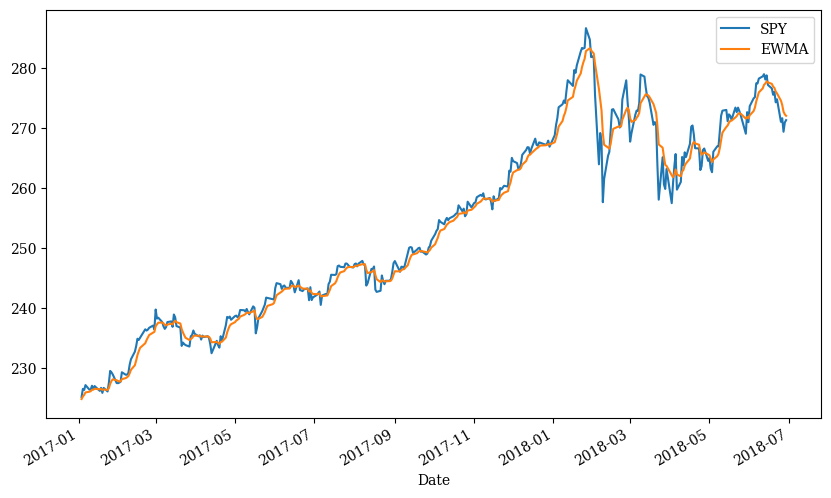

In [63]:
# Plot the results
data[data.index > '2017-1-1'].plot(figsize=(10, 6))

In [65]:
def ewma_py(x, alpha):
 y = np.zeros_like(x)
 y[0] = x[0]
 for i in range(1, len(x)): 
    y[i] = alpha * x[i] + (1-alpha) * y[i-1]
 return y

%time data['EWMA_PY'] = ewma_py(data[sym], alpha) # Applies the function to the Series object directly (i.e., the column).

CPU times: total: 0 ns
Wall time: 33.9 ms


In [66]:
%time data['EWMA_PY'] = ewma_py(data[sym].values, alpha) # Applies the function to the ndarray object containing the raw data.

CPU times: total: 0 ns
Wall time: 4 ms


#### Numba

In [67]:
# Apply Numba function
ewma_nb = numba.jit(ewma_py)

C:\Users\Franc\AppData\Local\Temp\ipykernel_36672\2567006979.py:2: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



In [69]:
%timeit data['EWMA_NB'] = ewma_nb(data[sym], alpha)

4.5 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
